In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

from torchvision import transforms, datasets, utils
import torchvision.models as models
from torch.utils.data import DataLoader, Subset
from torchsummary import summary

import matplotlib.pyplot as plt
import numpy as np
import copy
import os
import PIL
from sklearn.model_selection import StratifiedShuffleSplit as SSS

In [54]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
# device = 'cpu'
print(device)

cpu


In [60]:
data_transform =transforms.Compose([
    transforms.ToTensor()
])

# load datasets
DATA_PATH = '../data/stl-10'

train = datasets.STL10(DATA_PATH, split='train', download=True, transform=data_transform)
test = datasets.STL10(DATA_PATH, split='test', download=True, transform=data_transform)

# check data
img, _ = train[1]
print(img.shape)
print(len(train), len(test))

meanRGB = [np.mean(x.numpy(), axis=(1, 2)) for x, _ in train]
stdRGB = [np.std(x.numpy(), axis=(1, 2)) for x, _ in train]

meanR = np.mean([m[0] for m in meanRGB])
meanG = np.mean([m[1] for m in meanRGB])
meanB = np.mean([m[2] for m in meanRGB])

stdR = np.mean([s[0] for s in stdRGB])
stdG = np.mean([s[1] for s in stdRGB])
stdB = np.mean([s[2] for s in stdRGB])

train_transform = transforms.Compose([
    transforms.Resize(70), # 256
    transforms.FiveCrop(64), # 224
    transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),
    transforms.Normalize([meanR, meanG, meanB], [stdR, stdG, stdB])
])

# test_transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize([meanR, meanG, meanB], [stdR, stdG, stdB]),
#     transforms.Resize(224)
# ])

train.transform = train_transform
test.transform = train_transform # use test as validation dataset
# test.transform = test_transform

print(train.data.shape)
print(test.data.shape)

Files already downloaded and verified
Files already downloaded and verified
torch.Size([3, 96, 96])
5000 8000
(5000, 3, 96, 96)
(8000, 3, 96, 96)


/var/folders/81/_1yshp9s2sxb1nghxqpzk7b40000gn/T/ipykernel_94268/2137692410.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  random_idx = int(np.random.randint(0, len(train), 1))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


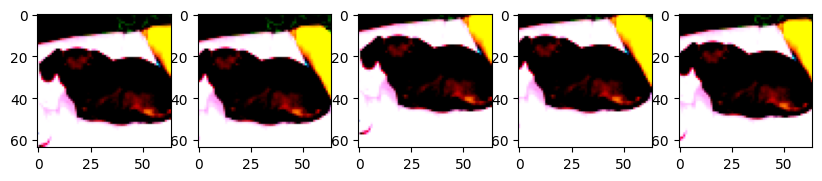

In [61]:
def show_imgs(imgs, color=True):
    for i, img in enumerate(imgs):
        npimg = img.numpy()
        plt.subplot(1, imgs.shape[0], i+1)
        plt.imshow(np.transpose(npimg, (1, 2, 0))) 

np.random.seed(0)
torch.manual_seed(0)

random_idx = int(np.random.randint(0, len(train), 1))
img, label = train[random_idx]

plt.figure(figsize=(10, 10))
show_imgs(img)

In [62]:
train_loader = DataLoader(train, batch_size=32)
valid_loader = DataLoader(test, batch_size=32)

In [63]:
# VGG type dict
# int : output channnels after conv layer
# 'M' : max pooling layer

VGG_types = {
    'VGG11' : [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13' : [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16' : [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512,'M', 512, 512, 512, 'M'],
    'VGG19' : [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512,'M', 512, 512, 512, 512, 'M']
}

In [74]:
class Vggnet(nn.Module):
    def __init__(self, model ,in_channels=3, num_classes=10, init_weights=True):
        super(Vggnet, self).__init__()
        self.in_channels = in_channels

        self.conv_layers = self.create_conv_layers(VGG_types[model])

        self.fcs = nn.Sequential(
            nn.Linear(512 * 2 * 2, 4096), # 512 * 7 * 7
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, num_classes)
        )

        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fcs(x)

        return x
    
    def create_conv_layers(self, architecture):
        layers = []
        in_channels = self.in_channels

        for x in architecture:
            if type(x) == int:
                out_channels = x

                layers += [
                    nn.Conv2d(in_channels, out_channels, kernel_size=(3, 3), stride=1, padding=1),
                    nn.BatchNorm2d(x),
                    nn.ReLU()
                ]
                in_channels = x
            elif x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]

        return nn.Sequential(*layers)
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

model = Vggnet('VGG16', in_channels=3, num_classes=10, init_weights=True).to(device)
print(model)

Vggnet(
  (conv_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), paddi

In [75]:
criterion = nn.CrossEntropyLoss(reduction='sum')
optimizer = optim.Adam(model.parameters(), lr=0.01)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    
# StepLR : per steps, multiple gamma to learning_rate
lr_scheduler = StepLR(optimizer, step_size=30, gamma=0.1)

In [76]:
# calculate accuracy per batch
def get_accuracy(output, target):
    pred = output.argmax(dim=1, keepdim=True)
    corrects = pred.eq(target.view_as(pred)).sum().item()
    return corrects

# calculate loss per batch
def loss_batch(criterion, output, target, optimizer=None):
    loss = criterion(output, target)
    acc = get_accuracy(output, target)
    if optimizer is not None:
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return loss.item(), acc

# calculate performance loss, accuracy per epoch
def loss_epoch(model, loss_func, dataset_dl, sanity_check=False, optimizer=None):
    running_loss = 0
    running_acc = 0
    len_data = float(len(dataset_dl.dataset))

    for xb, yb in dataset_dl:
        xb = xb.to(device)
        yb = yb.to(device)

        bs, ncrops, c, h, w = xb.size()
        output_= model(xb.view(-1, c, h, w))
        output = output_.view(bs, ncrops, -1).mean(1)

        loss_b, acc_b = loss_batch(loss_func, output, yb, optimizer)
        running_loss += loss_b

        if acc_b is not None:
            running_acc += acc_b
        
        if sanity_check: # if sannity_check is True, only one batch is processed
            break

    loss = running_loss / len_data
    acc = running_acc / len_data
    return loss, acc

In [77]:
def train_val(model, params):
    num_epochs = params['num_epochs']
    loss_func = params['loss_func']
    optimizer = params['optimizer']
    train_dl = params['train_dl']
    val_dl = params['val_dl']
    sanity_check = params['sanity_check']
    lr_scheduler = params['lr_scheduler']
    path2weights = params['path2weights']

    loss_history = {
        'train': [],
        'val': []
    }

    acc_history = {
        'train': [],
        'val': []
    }

    best_model_weights = copy.deepcopy(model.state_dict())
    best_loss = float('inf')

    for epoch in range(num_epochs):
        current_lr = get_lr(optimizer)
        print('Epoch {}/{}, current lr = {}'.format(epoch, num_epochs-1, current_lr))

        model.train()
        train_loss, train_acc = loss_epoch(model, loss_func, train_dl, sanity_check, optimizer)
        loss_history['train'].append(train_loss)
        acc_history['train'].append(train_acc)

        model.eval()
        with torch.no_grad():
            val_loss, val_acc = loss_epoch(model, loss_func, val_dl, sanity_check)


        if val_loss < best_loss:
            best_loss = val_loss
            best_model_weights = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), path2weights)
            print('Copied best model weights!')
        
        loss_history['val'].append(val_loss)
        acc_history['val'].append(val_acc)

        lr_scheduler.step()

        print('train loss: %.6f, dev loss: %.6f, accuracy: %.2f' % (train_loss, val_loss, val_acc*100))
        print('-'*15)

        if epoch % 1 == 0:
            model.load_state_dict(best_model_weights)

    return model, loss_history, acc_history

In [78]:
os.makedirs('./models', exist_ok=True)

params_train = {
    'num_epochs': 2, # 100
    'optimizer': optimizer,
    'loss_func': criterion,
    'train_dl': train_loader,
    'val_dl': valid_loader,
    'sanity_check': False,
    'lr_scheduler': lr_scheduler,
    'path2weights': './models/weights.pt'
}

model, loss_hist, acc_hist = train_val(model, params_train)

Epoch 0/1, current lr = 0.01
Copied best model weights!
train loss: 12.284872, dev loss: 2.304426, accuracy: 10.00
---------------
Epoch 1/1, current lr = 0.01
train loss: 2.551199, dev loss: 2.319958, accuracy: 10.00
---------------


In [ ]:
num_epochs = params_train['num_epochs']


plt.title('Train-Val Loss')
plt.plot(range(1, num_epochs+1), loss_hist['train'], label='train loss')
plt.plot(range(1, num_epochs+1), loss_hist['val'], label='val loss')
plt.legend()
plt.show()

plt.title('Train-Val Accuracy')
plt.plot(range(1, num_epochs+1), acc_hist['train'], label='train accuracy')
plt.plot(range(1, num_epochs+1), acc_hist['val'], label='val accuracy')
plt.legend()
plt.show()